# Installing and Imports libraries

In [47]:
#%pip install pylab

In [48]:
# Imports
import numpy as np
import pandas as pd
from itertools import combinations
from scipy.stats import ttest_ind
import os
import sys
import PIL
import cv2


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# plt
import matplotlib.pyplot as plt
import seaborn as sns

# increasing of default size of graphs
#from pylab import rcParams
#rcParams['figure.figsize'] = 8, 4

# graphs in svg looks more fine
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# printing versions of numpy and python
print('Python         :', sys.version.split('\n')[0])
print('Numpy          :', np.__version__)

Python         : 3.10.10 (tags/v3.10.10:aad5f6a, Feb  7 2023, 17:20:36) [MSC v.1929 64 bit (AMD64)]
Numpy          : 1.24.2


In [49]:
# Imports of local libs
sys.path.insert(1, '../')

from utils.functions import make_unzip, get_translite, prepare_vladenie
from utils.functions import pre_an_types_feat, prints_types_feat
from utils.functions import col_preanalisys, ch_name_col, numb_type_analisys
from utils.paths import create_paths
from utils.read_config import config_reader

In [50]:
# read defined params
config = config_reader('../config/data_config.json')
paths = create_paths(config)

# fix RANDOM_SEED for repeating results
RANDOM_SEED = config.RANDOM_SEED
np.random.seed(RANDOM_SEED)

## Reading Data

In [51]:
# unzip data
is_unzip = False
make_unzip(paths.PATH_TO_ZIP, paths.PATH_DATA, is_unzip=is_unzip)

Zip-archive "sf-dst-car-price-prediction-part2.zip" no need to unpack, to unpack change value of param "is_unzip" to "True"


In [52]:
# Reading '.cvs' data files
train = pd.read_csv(os.path.join(paths.PATH_DATA, 'train.csv'))
test = pd.read_csv(os.path.join(paths.PATH_DATA, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(paths.PATH_DATA, 'sample_submission.csv'))

# Let's look at the train data set columns
print(train.columns)

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'price', 'productionDate', 'sell_id',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение',
       'ПТС', 'Привод', 'Руль'],
      dtype='object')


In [53]:
train.sample(2)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
1772,седан,MERCEDES,чёрный,Состояние нового автомобиля.,5.5 LTR,585 N12,бензин,2900,2013,S_KLASSE_AMG,...,7100000.0,2016,1100165184,SEDAN AUTOMATIC 5.5,автоматическая,1 владелец,2 года и 6 месяцев,Оригинал,полный,Левый
4813,хэтчбек 5 дв.,AUDI,красный,При покупке автомобиля:\n► Возможна покупка ав...,2.0 LTR,150 N12,бензин,224000,2004,A3,...,389000.0,2005,1099744048,HATCHBACK_5_DOORS AUTOMATIC 2.0,автоматическая,3 или более,NaN,Оригинал,передний,Левый


In [54]:
#translite_columns = [get_translite(x) for x in train.columns]
#train.columns = translite_columns
#train.head(3)

In [55]:
# Comparison of the number of columns in training and test datasets
print(f'Num train cols: {len(train.columns)}, ', f'Num test cols: {len(test.columns)}')
print(f'Col not in test: {set(train.columns) - set(test.columns)}')

# Col with name 'price' - its a target

Num train cols: 22,  Num test cols: 21
Col not in test: {'price'}


In [56]:
# print info about train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [57]:
# The number of unique values for each feature
print(train.nunique())

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64


In [58]:
# Let's see if the number of unique values in train exceeds that of test
np.sum(train.drop('price', axis=1).nunique() - test.nunique() < 0)

# all values >=0 -> the number of unique values in train not exceed in test

0

In [59]:
# Automatic types of train features pre-analisys
feat_bin, feat_cat, feat_cat_large, feat_other = pre_an_types_feat(train)
prints_types_feat(feat_bin, feat_cat, feat_cat_large, feat_other)

Binary features: 
['ПТС', 'Руль'] 
 ----------------------------------------
Categorical features with 2 < num_cat <= 20: 
['bodyType', 'brand', 'color', 'fuelType', 'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Привод'] 
 ----------------------------------------
Categorical or num features with unique num of values: 20 < num_cat <= 50: 
['engineDisplacement', 'modelDate', 'productionDate'], 
 ----------------------------------------
Num or other types of features with unique num of values > 50: 
['description', 'enginePower', 'mileage', 'model_info', 'name', 'price', 'sell_id', 'vehicleConfiguration', 'Владение']


In [60]:
# Automatic types of test features pre-analisys
feat_bin, feat_cat, feat_cat_large, feat_other = pre_an_types_feat(test)
prints_types_feat(feat_bin, feat_cat, feat_cat_large, feat_other)

Binary features: 
['ПТС', 'Руль'] 
 ----------------------------------------
Categorical features with 2 < num_cat <= 20: 
['bodyType', 'brand', 'color', 'fuelType', 'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Привод'] 
 ----------------------------------------
Categorical or num features with unique num of values: 20 < num_cat <= 50: 
['engineDisplacement', 'modelDate', 'productionDate'], 
 ----------------------------------------
Num or other types of features with unique num of values > 50: 
['description', 'enginePower', 'mileage', 'model_info', 'name', 'sell_id', 'vehicleConfiguration', 'Владение']


### Types of features 


<details>
<summary> Display types of all used features </summary> <br>

* bodyType - categorical
* brand - categorical
* color - categorical
* description - text
* engineDisplacement - numeric, represented as text
* enginePower - numeric, represented as text
* fuelType - categorical
* mileage - numeric
* modelDate - numeric or categorical with large num categories
* model_info - categorical
* name - categorical, needs to reduce nums of unique values
* numberOfDoors - categorical
* price - numeric, target
* productionDate - numeric or categorical with large num categories
* sell_id - text, link to images (images are available at the addresses based on sell_id)
* vehicleConfiguration - don't use (cause it's a combination of other columns)
* vehicleTransmission - categorical
* Владельцы - categorical
* Владение - numeric, represented as text
* ПТС - binary
* Привод - categorical
* Руль - binary

Note: Conclusions were done using manual analysis of train and test DataFrames. 
</details>

## EDA

### NaN analisys

In [61]:
# copying train and test
df_train = train.copy()
df_test = test.copy()

In [62]:
# NaN analisys in df_train
mask_train_na = df_train.isna().sum() != 0
print(f'Cols with NaN values in df_train: \n{df_train.isna().sum()[mask_train_na]}')
print('--'*20)

# NaN analisys in df_test
mask_test_na = df_test.isna().sum() != 0
print(f'Cols with NaN values in df_test: \n{df_test.isna().sum()[mask_test_na]}')

Cols with NaN values in df_train: 
Владельцы       1
Владение     4326
dtype: int64
----------------------------------------
Cols with NaN values in df_test: 
Владение    1092
dtype: int64


**df_train**:
1. in **Владение** there are too many NaN the column will be used to create a new attribute: 
    - take into account there is/is not NaN 
    - conversion to a number & if NaN -> replace to 0   
2. One NaN sample in **Владельцы**: 
    - so we can drop it 
    - replace to value '3 или более', cause car 2001 year production -> train.loc[train['Владельцы'].isna(), 'Владельцы'] = '3 или более'

**df_test**:
1. in **Владение** there are too many NaN the column will be used to create a new attribute: 
    - take into account there is/is not NaN 
    - conversion to a number & if NaN -> replace to 0  

In [63]:
print('Before prepare to num feat')
print(df_train['Владение'].head(3))

# prepare feature 'Владение' to num feature
df_train['Владение'] = df_train.Владение.apply(prepare_vladenie)
df_test['Владение'] = df_test.Владение.apply(prepare_vladenie)

print('After prepare to num feat')
print(df_train['Владение'].head(3))

Before prepare to num feat
0                  NaN
1    8 лет и 6 месяцев
2                  NaN
Name: Владение, dtype: object
After prepare to num feat
0      0
1    102
2      0
Name: Владение, dtype: int64


In [64]:
print(len(df_train))
df_train.dropna(subset=['Владельцы'], inplace=True)
print(len(df_train))

6682
6681


### Object columns data pre-analisys

In [65]:
# Names of object features
obj_cols = df_train.dtypes[train.dtypes==object].index
print(obj_cols)


Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'model_info', 'name', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод',
       'Руль'],
      dtype='object')


In [66]:
for col in set(obj_cols) - set(['description']):
    col_preanalisys(df_train, df_test, col)
print('In other columns all unique values of df_test are contained in df_train')

The number of unique values in the enginePower column in df_train is greater or equal than in df_test.
 The number of enginePower values in test that are not present in train: 8
----------------------------------------
The number of unique values in the model_info column in df_train is greater or equal than in df_test.
 The number of model_info values in test that are not present in train: 4
----------------------------------------
The number of unique values in the name column in df_train is greater or equal than in df_test.
 The number of name values in test that are not present in train: 76
----------------------------------------
The number of unique values in the Владение column in df_train is greater or equal than in df_test.
 The number of Владение values in test that are not present in train: 7
----------------------------------------
The number of unique values in the vehicleConfiguration column in df_train is greater or equal than in df_test.
 The number of vehicleConfigurati

In [67]:
# Converting the 'name' column to 'ch_name' to exclude data duplicated in other columns
df_train['ch_name'] = df_train.name.apply(ch_name_col)
df_test['ch_name'] = df_test.name.apply(ch_name_col)

# Удаление колонки name
df_train.drop(['name'], axis=1, inplace=True)
df_test.drop(['name'], axis=1, inplace=True)

In [68]:
# bringing all values of the 'engineDisplacement' col to the form 'X.Y LTR'
df_train.engineDisplacement.replace('undefined LTR', '0.0 LTR', inplace=True)
df_test.engineDisplacement.replace('undefined LTR', '0.0 LTR', inplace=True)

# bringing all values of the 'engineDisplacement' col to float value
df_train['ch_engineDisplacement'] = df_train.engineDisplacement.apply(lambda x: float(x[:-4])) 
df_test['ch_engineDisplacement'] = df_test.engineDisplacement.apply(lambda x: float(x[:-4])) 

In [69]:
# bringing all values of the 'enginePower' col to float value
df_train['ch_enginePower'] = df_train.enginePower.apply(lambda x: float(x[:-4]))
df_test['ch_enginePower'] = df_test.enginePower.apply(lambda x: float(x[:-4]))

### EDA numb_cols

In [70]:
# Names of numerical features
num_cols = df_train.dtypes[df_train.dtypes!=object].index
print(num_cols)

Index(['mileage', 'modelDate', 'numberOfDoors', 'price', 'productionDate',
       'sell_id', 'Владение', 'ch_engineDisplacement', 'ch_enginePower'],
      dtype='object')


### **mileage**


 Column: mileage  

Statistical parameters of the column mileage:
25-й percentile: 59144.0, 75-й percentile: 168000.0, IQR: 108856.0,  Boundaries outliers: [-104140.0, 331284.0]. 

There are outliers in the region of maximum values


count      6681.000000
mean     120516.701991
std       81459.112729
min           1.000000
25%       59144.000000
50%      111000.000000
75%      168000.000000
max      999999.000000
Name: mileage, dtype: float64

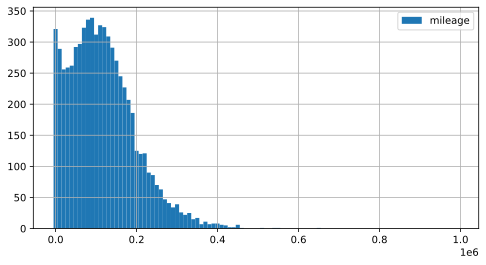

In [71]:
## statistical analisys in col mileage of df_train
numb_type_analisys(df_train, 'mileage', 
                   bins_step=(df_train.mileage.max() - df_train.mileage.min())//100)

In [80]:
# Let's see information for car with maximum mileage in df_train
print(df_train[df_train['mileage']==df_train['mileage'].max()].description.values)
df_train[df_train['mileage']==df_train['mileage'].max()]

['Рейстайлинг. \nОдин хозяин по ПТС. Оригинальный пробег 98500 км.\n\nСостояние Очень Хорошее ! \nСделано ТО + замена масла в АКПП\nНовая резина !\n\nТехнически и юридически безупречен.\n \nКуплен в августа 2009 , \nБережная эксплуатация и своевременная замена всех расходников. \nВсе системы работают исправно. \nДва ключа. \nМосковские с номера. \nАВТОМОБИЛЬ НЕ ТРЕБУЕТ ВЛОЖЕНИЙ. \nКожанны салон\nПодушки безопасности \nABS EBD ESP \nПарктроник \nТеплый шарф.\nОхранная система \nИммобилайзер \nЦентральный замок\nДатчик света \nДатчик дождя \nОмыватель фар \nКсеноновые фары \nБортовой компьютер \nКруиз контроль \nМультируль \nЭлектропривод богажника \nЭлектрические зеркала с обогревом \nОбогрев сидений \nКлимат контроль 2-зонный \nПротивотуманные фары\nПосредникам, автосалонам и рекламным агентам - просьба не беспокоить.\nТорг.']


,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,ch_name,ch_engineDisplacement,ch_enginePower
1922,родстер,MERCEDES,чёрный,Рейстайлинг. \nОдин хозяин по ПТС. Оригинальны...,1.8 LTR,184 N12,бензин,999999,2008,SLK_KLASSE,...,ROADSTER AUTOMATIC 1.8,автоматическая,1 владелец,131,Оригинал,задний,Левый,200,1.8,184.0


High mileage in cars is not uncommon, so we will not exclude outliers based on the data above. However, there is a clear outlier in the area of maximum values: for a 2008 car, a mileage of 999999 km is indicated. Which is quite a lot. When reading the 'description' it is indicated: "Original mileage 98500 km", which is suspiciously small, but clearly not 999999 km. From here, you can either delete this value or correct it to 98500 or 99999. Let's try the second one (99999), since it is close to 98500 and could have specified an extra digit when filling in the data.

In [81]:
# changing the outlier value to 99999
df_train.loc[df_train['mileage']==df_train['mileage'].max(), 'mileage'] = 99999


 Column: mileage  

Statistical parameters of the column mileage:
25-й percentile: 59144.0, 75-й percentile: 168000.0, IQR: 108856.0,  Boundaries outliers: [-104140.0, 331284.0]. 

There are outliers in the region of maximum values


count      6681.000000
mean     120381.991618
std       80745.527022
min           1.000000
25%       59144.000000
50%      111000.000000
75%      168000.000000
max      652000.000000
Name: mileage, dtype: float64

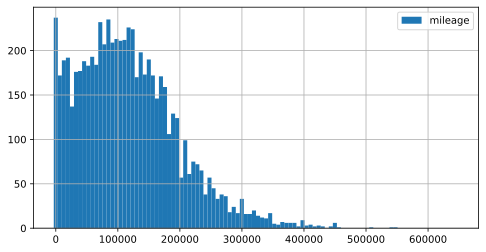

In [82]:
## statistical analisys in col mileage of df_train AGAIN
numb_type_analisys(df_train, 'mileage', 
                   bins_step=(df_train.mileage.max() - df_train.mileage.min())//100)


 Column: mileage  

Statistical parameters of the column mileage:
25-й percentile: 59373.0, 75-й percentile: 165375.5, IQR: 106002.5,  Boundaries outliers: [-99630.75, 324379.25]. 

There are outliers in the region of maximum values


count       1671.000000
mean      119724.664871
std        83467.240436
min            1.000000
25%        59373.000000
50%       109000.000000
75%       165375.500000
max      1000000.000000
Name: mileage, dtype: float64

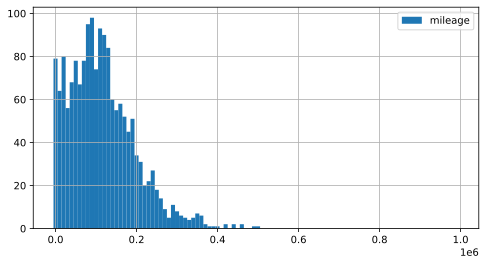

In [83]:
## ## statistical analisys in col mileage of df_test
numb_type_analisys(df_test, 'mileage', 
                   bins_step=(df_test.mileage.max() - df_test.mileage.min())//100)

In [84]:
# Let's see information for car with maximum mileage in df_test
df_test[df_test['mileage']==df_test['mileage'].max()]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,ch_name,ch_engineDisplacement,ch_enginePower
960,родстер,MERCEDES,красный,"Обмен не предлагать ,по птс 394 лс",6.0 LTR,394 N12,бензин,1000000,1989,SL_KLASSE,...,ROADSTER AUTOMATIC 6.0,автоматическая,2 владельца,0,Дубликат,задний,Левый,600,6.0,394.0


Only one car in the test set has a mileage of 1,000,000 km and there is no car with a mileage of more than 500,000 km. Since the description does not specify which mileage, we exclude this line

In [85]:
# Exclude row with mileage 1000000 км
df_test = df_test.loc[df_test['mileage']<1000000] 
# df_test.loc[df_test['mileage']<df_test['mileage'].max()]


 Column: mileage  

Statistical parameters of the column mileage:
25-й percentile: 59309.5, 75-й percentile: 165188.25, IQR: 105878.75,  Boundaries outliers: [-99508.625, 324006.375]. 

There are outliers in the region of maximum values


count      1670.000000
mean     119197.553892
std       80662.231754
min           1.000000
25%       59309.500000
50%      109000.000000
75%      165188.250000
max      500000.000000
Name: mileage, dtype: float64

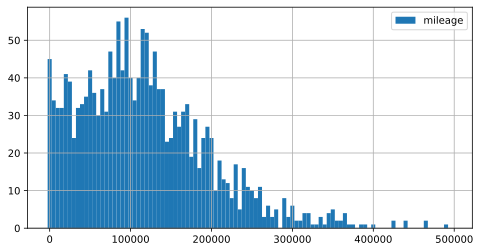

In [86]:
## statistical analisys in col mileage of df_test AGAIN
numb_type_analisys(df_test, 'mileage', 
                   bins_step=(df_test.mileage.max() - df_test.mileage.min())//100)

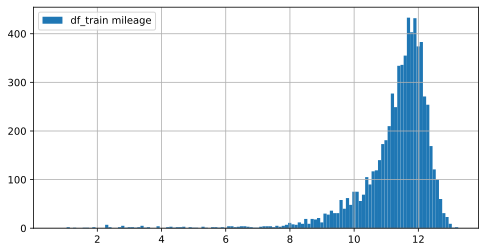

In [87]:
## looking for hist of log mileage column of df_train 
col = 'mileage'
np.log(df_train[col]).hist(bins=np.arange(min(np.log(1 + df_train[col])), 
                                       max(np.log(1 + df_train[col])), 0.1),
                           align='left',
                           label='df_train ' + col)
plt.legend()

# logarithm changes the character of the distribution and reduces the scale of the numerical feature

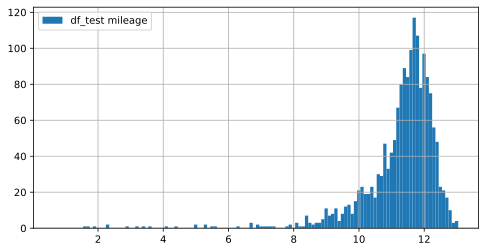

In [88]:
## looking for log hist of test mileage 
col = 'mileage'
np.log(df_test[col]).hist(bins=np.arange(min(np.log(1+df_test[col])), 
                                       max(np.log(1+df_test[col])), 0.1),
                           align='left',
                           label='df_test '+col)
plt.legend()

# logarithm changes the character of the distribution and reduces the scale of the numerical feature

### **modelDate**

In [41]:
## modelDate train
col='modelDate'
numb_type_analisys(df_train, col, bins_step=1)

In [42]:
df_train[df_train['modelDate']==df_train['modelDate'].min()]

In [43]:
# Смотрим, что на картинку предполагаемого выброса в train
image = PIL.Image.open('../input/sf-dst-car-price-prediction-part2/img/img/'+
                       str(df_train[df_train['modelDate']==df_train['modelDate'].min()].sell_id.values[0])+
                       '.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Что ж, похоже что авто, действительно 1975 года, оставляем =)

In [44]:
## modelDate test
numb_type_analisys(df_test, col, bins_step=1)

In [45]:
df_test[df_test['modelDate']==df_test['modelDate'].min()]

In [46]:
# Смотрим, что на картинку предполагаемого выброса в test
image = PIL.Image.open('../input/sf-dst-car-price-prediction-part2/img/img/'+
                       str(df_test[df_test['modelDate']==df_test['modelDate'].min()].sell_id.values[0])+
                       '.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# И этот авто похож на авто 1971 года, оставляем =)

In [47]:
## looking log hist of train modelDate
col = 'modelDate'
np.log(df_train[col]).hist(bins=np.arange(min(np.log(df_train[col])), 
                                       max(np.log(df_train[col])), 0.0005),
                           align='left',
                           label=col)
plt.legend()
# логарифмирование сильно не изменяет характер распределения, только уменьшает масштаб

In [48]:
## looking log hist of test modelDate
col = 'modelDate'
np.log(df_test[col]).hist(bins=np.arange(min(np.log(df_test[col])), 
                                       max(np.log(df_test[col])), 0.0005),
                           align='left',
                           label=col)
plt.legend()
# логарифмирование сильно не изменяет характер распределения, только уменьшает масштаб


### **numberOfDoors**


In [49]:
## numberOfDoors df_train
col='numberOfDoors'
numb_type_analisys(df_train, col, bins_step=0.5)

In [50]:
## numberOfDoors df_test
col='numberOfDoors'
numb_type_analisys(df_test, col, bins_step=0.5)

### Распределения в целом схожи, двухдверные авто бывают, считаем, что выбросов нет.

## **productionDate**

In [51]:
## productionDate df_train
col='productionDate'
numb_type_analisys(df_train, col, bins_step=1)

In [52]:
## productionDate df_test
col='productionDate'
numb_type_analisys(df_test, col, bins_step=1)

### modelDate & productionDate скорее всего будут сильно скоррелированы и будем избавляться от одного из признаков

## **Владение**

In [53]:
## Владение df_train исключаем 0 из анализа, т.к. сделано искуственно из NaN и слишком много
col='Владение'
numb_type_analisys(df_train[df_train['Владение']>0], col, bins_step=1)

# Похоже, что выбросов нет, т.к. возраст авто и время владения близки
#см. df_train[df_train['Владение']>300]

In [54]:
## Владение df_test исключаем 0 из анализа, т.к. сделано искуственно из NaN и слишком много
col='Владение'
numb_type_analisys(df_test[df_test['Владение']>0], col, bins_step=1)

# Похоже, что выбросов нет, т.к. возраст авто и время владения близки
#см. df_test[df_test['Владение']>300]

## **ch_engineDisplacement**

In [55]:
## ch_engineDisplacement df_train
col='ch_engineDisplacement'
numb_type_analisys(df_train, col, bins_step=0.1)

# результат ожидаем, больше всего моторов с двигателем 2 и 3 литра

In [56]:
## ch_engineDisplacement df_test
col='ch_engineDisplacement'
numb_type_analisys(df_test, col, bins_step=0.1)

# результат ожидаем, больше всего моторов с двигателем 2 и 3 литра

In [57]:
## looking log hist of train ch_engineDisplacement
col = 'ch_engineDisplacement'
np.log(df_train[col]).hist(bins=np.arange(min(np.log(1+df_train[col])), 
                                          max(np.log(1+df_train[col])), 0.05),
                           align='left',
                           label=col)
plt.legend()
# логарифмирование делает распределение более симметричным и уменьшает масштаб

In [58]:
## looking log hist of test ch_engineDisplacement
col = 'ch_engineDisplacement'
np.log(df_test[col]).hist(bins=np.arange(min(np.log(1+df_test[col])), 
                                         max(np.log(1+df_test[col])), 0.05),
                           align='left',
                           label=col)
plt.legend()

# логарифмирование делает распределение более симметричным и уменьшает масштаб

## **ch_enginePower**

In [59]:
## ch_enginePower df_train
col='ch_enginePower'
numb_type_analisys(df_train, col, bins_step=10)

In [60]:
## ch_enginePower df_test
col='ch_enginePower'
numb_type_analisys(df_test, col, bins_step=10)

In [61]:
## looking log hist of train ch_engineDisplacement
col = 'ch_enginePower'
np.log(df_train[col]).hist(bins=np.arange(min(np.log(1+df_train[col])), 
                                          max(np.log(1+df_train[col])), 0.05),
                           align='left',
                           label=col)
plt.legend()
# логарифмирование делает распределение более симмтричным и уменьшает масштаб

In [62]:
## looking log hist of test ch_engineDisplacement
col = 'ch_enginePower'
np.log(df_test[col]).hist(bins=np.arange(min(np.log(1+df_test[col])), 
                                         max(np.log(1+df_test[col])), 0.05),
                           align='left',
                           label=col)
plt.legend()
# логарифмирование делает распределение более симмтричным и уменьшает масштаб

In [63]:
# Смотрим еще раз, как изменяются графики после логарифмирования

numb_cols = [x for x in df_train.dtypes[df_train.dtypes!=object].index 
             if x not in ['sell_id', 'price', 'numberOfDoors']]

ind_j = 0

def plot_col(df, col, ind):
    axes[ind].hist(df[col], 
                   bins = 25,
                   align='left')
    axes[ind].set_title(col)
    
    axes[ind+1].hist(np.log(1+df_train[col]),
                          bins = 25,
                          align='left')
    axes[ind+1].set_title('log ' + col)
    
fig, axes = plt.subplots(1, 4, figsize=(16, 2))

for col in numb_cols:
    if ind_j < 3:
        plot_col(df_train, col, ind_j)
        ind_j += 2
    else:
        plt.show()
        ind_j = 0
        fig, axes = plt.subplots(1, 4, figsize=(16, 2))
        plot_col(df_train, col, ind_j)
        ind_j += 2

In [64]:
df_train.corr()

1. **engineDisplacement** и **enginePower** имеют сильную корреляцию, одновременное их использование не рекомендуется. В связи с этим и с тем, что enginePower имеет более сильную корреляцию с price (target-переменная), чем engineDisplacement: enginePower можно переделать в числовой признак (+ в тесте есть значения отсуствующие в train), а engineDisplacement - оставить в категориальном признаке.
2. Аналогично для **modelDate** и **productionDate**, пробуем productionDate переделать в числовой признак, а modelDate - исключим.
3. **mileage** имеет сильную обратную корреляцию с modelDate и productionDate. Для начала попробуем посмотреть на рассчитанное качество.
2. target переменная price:
- имеет прямую сильную корреляцию с enginePower, engineDisplacement;
- имеет обратную сильную корреляцию с mileage;
- имеет прямую сильную корреляцию с modelDate, productionDate;

In [65]:
# сморим матрицу корреляции для np.log(df_train), выводы примерно те же, что и без np.log
df_train_log = np.log(1+df_train[df_train.dtypes[df_train.dtypes!=object].index].copy())
df_train_log.corr()

## Анализ номинативных переменных

In [66]:
label_cols = list(df_train.dtypes[df_train.dtypes==object].index)
label_cols

In [67]:
## 4. Анализ номинативных переменных
def get_boxplot(column, data):
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.boxplot(x=column, y='price',
                data=data,  # данных в столбцах не много
                ax=ax)
    plt.xticks(rotation=90)
    ax.set_title('Boxplot for ' + column)
    plt.show()

# data=df_train.loc[df_train.loc[:, column].isin(df_train.loc[:, column].value_counts().index[:10])]
# когда в столбце много значений и выделяем 10 наиболее встречающихся 

In [68]:
column = 'bodyType'
data=df_train.loc[df_train.loc[:, column].isin(df_train.loc[:, column].value_counts().index[:10])]
get_boxplot(column, data)

In [69]:
column = 'brand'
data=df_train.loc[df_train.loc[:, column].isin(df_train.loc[:, column].value_counts().index[:10])]
get_boxplot(column, data)

In [70]:
column = 'color'
data=df_train.loc[df_train.loc[:, column].isin(df_train.loc[:, column].value_counts().index[:10])]
get_boxplot(column, data)

In [71]:
column = 'engineDisplacement'
data=df_train.loc[df_train.loc[:, column].isin(df_train.loc[:, column].value_counts().index[:15])]
get_boxplot(column, data)

In [72]:
column = 'fuelType'
data=df_train.loc[df_train.loc[:, column].isin(df_train.loc[:, column].value_counts().index[:15])]
get_boxplot(column, data)

In [73]:
column = 'model_info'
data=df_train.loc[df_train.loc[:, column].isin(df_train.loc[:, column].value_counts().index[:15])]
get_boxplot(column, data)

In [74]:
column = 'vehicleConfiguration'
data=df_train.loc[df_train.loc[:, column].isin(df_train.loc[:, column].value_counts().index[:15])]
get_boxplot(column, data)

In [75]:
column = 'vehicleTransmission'
data=df_train.loc[df_train.loc[:, column].isin(df_train.loc[:, column].value_counts().index[:15])]
get_boxplot(column, data)

In [76]:
column = 'Владельцы'
data=df_train.loc[df_train.loc[:, column].isin(df_train.loc[:, column].value_counts().index[:15])]
get_boxplot(column, data)

In [77]:
column = 'ПТС'
data=df_train.loc[df_train.loc[:, column].isin(df_train.loc[:, column].value_counts().index[:15])]
get_boxplot(column, data)

In [78]:
column = 'Привод'
data=df_train.loc[df_train.loc[:, column].isin(df_train.loc[:, column].value_counts().index[:15])]
get_boxplot(column, data)

In [79]:
column = 'Руль'
data=df_train.loc[df_train.loc[:, column].isin(df_train.loc[:, column].value_counts().index[:15])]
get_boxplot(column, data)

In [80]:
column = 'ch_name'
data=df_train.loc[df_train.loc[:, column].isin(df_train.loc[:, column].value_counts().index[:15])]
get_boxplot(column, data)

По графикам похоже, что все параметры могут влиять на оценку стоимости авто. Графики являются вспомогательным инструментом. Проверим, есть ли статистическая разница в распределении стоимости авто по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения стоимости авто по различным параметрам неразличимы

In [81]:
def get_stat_dif(column, alpha):
    """ aplpha - уровень значимости"""

    cols = df_train.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df_train.loc[df_train.loc[:, column] == comb[0], 'price'],
                     df_train.loc[df_train.loc[:, column] == comb[1], 'price']).pvalue \
                     <= alpha/len(combinations_all):  # Учли поправку Бонферони
            print(
                'Найдены статистически значимые различия для колонки {} с уровнем значимости {}'.format(
                    column, alpha))
            break
        else:
            print(
                'НЕ НАЙДЕНЫ статистически значимые различия для колонки {} с уровнем значимости {}'.format(
                    column, alpha))
            break

In [82]:
list(combinations(df_train.loc[:, 'brand'].value_counts().index[:], 2))

In [83]:
for col in list(set(label_cols)-set(['description'])):
        get_stat_dif(col, 0.01)

In [84]:
for col in list(set(label_cols)-set(['description'])):
        get_stat_dif(col, 0.05)

In [85]:
for col in list(set(label_cols)-set(['description'])):
        get_stat_dif(col, 0.1)

### **Вывод**: на основании проведенного анализа при обучении модели можно исключить признак 'Руль' и возможно изменить преобразование признака 'name' до нахождения данных из признака 'name', которые дадут статистически значимые различия при проверке нулевой гипотезы. Иначе, также исключить данный признак.